<a href="https://colab.research.google.com/github/cfenogli/Stock-Forecasting-BU/blob/main/LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import io
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader.data as web
import seaborn as sn

In [2]:
start =      dt.datetime(2000,1,1)
end =        dt.datetime(2016,12,31)
df =         web.DataReader('TSLA','yahoo',start,end)
train =      web.DataReader('TSLA','yahoo',start,end)

In [3]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,5.000,3.508,3.800,4.778,93831500,4.778
2010-06-30,6.084,4.660,5.158,4.766,85935500,4.766
2010-07-01,5.184,4.054,5.000,4.392,41094000,4.392
2010-07-02,4.620,3.742,4.600,3.840,25699000,3.840
2010-07-06,4.000,3.166,4.000,3.222,34334500,3.222


In [4]:
df.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
High,1640.0,2.619804e+01,1.894757e+01,3.326,6.049500e+00,3.007100e+01,4.416500e+01,5.828400e+01
Low,1640.0,2.525295e+01,1.836853e+01,2.996,5.780500e+00,2.854300e+01,4.272150e+01,5.608000e+01
Open,1640.0,2.574012e+01,1.866907e+01,3.228,5.948500e+00,2.956700e+01,4.347350e+01,5.753400e+01
Close,1640.0,2.573190e+01,1.866311e+01,3.160,5.908000e+00,2.948500e+01,4.353250e+01,5.720800e+01
Volume,1640.0,2.118811e+07,2.169151e+07,592500.000,5.800500e+06,1.550400e+07,2.810162e+07,1.858195e+08
Adj Close,1640.0,2.573190e+01,1.866311e+01,3.160,5.908000e+00,2.948500e+01,4.353250e+01,5.720800e+01


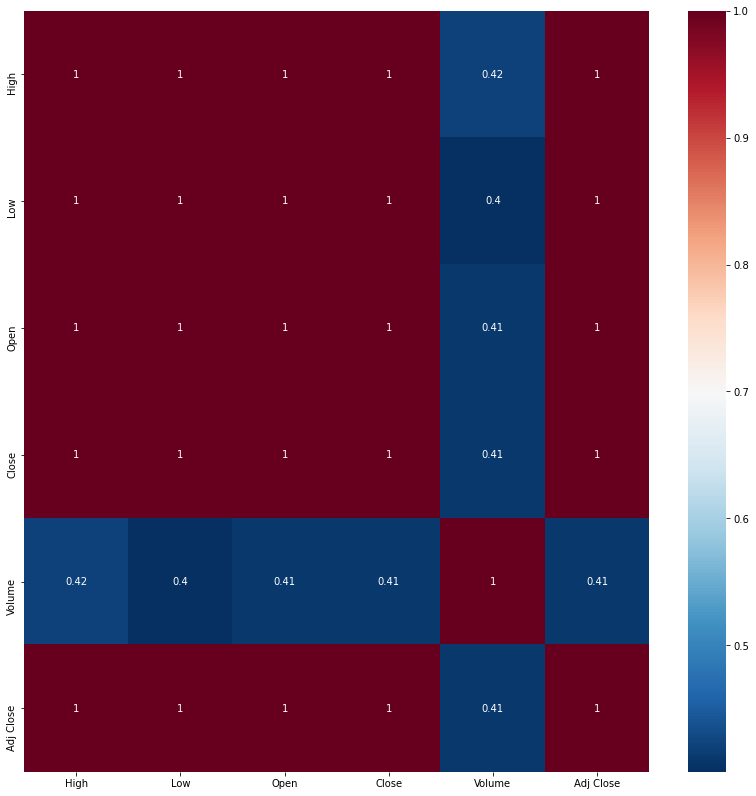

In [6]:
plt.figure(figsize=(14,14))
sn.heatmap(df.corr(),annot=True, cmap='RdBu_r');

In [7]:
#Low values 
train_data = df[['High','Low','Open','Volume','Adj Close']].values

In [8]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(train_data)

In [9]:
X_train = []
y_train = []
steps = 60
# (data, steps, features)
for i in range(steps,train_data.shape[0]):
  X_train.append(training_set_scaled[i-steps:i,0])
  y_train.append(training_set_scaled[i,0])

X_train,y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train,(X_train.shape[0], X_train.shape[1],5))

ValueError: ignored

In [170]:
#Should have 60 steps
X_train.shape

(1580, 60, 1)

In [171]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import metrics 

In [172]:
##For cross validation (splitting)
from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score
#from sklearn import svm

kf = KFold(n_splits=5, random_state=42, shuffle=True)

fold =                    1
history =                 {}
scores =                  []
error_rate =              []
total_error =             []
cross_val_X_train_data =  []
cross_val_X_test_data =   []
cross_val_y_train_data =  []
cross_val_y_test_data =   []
mse_per_fold =            []
loss_per_fold =           []

for train_index, test_index in kf.split(X_train,y_train):
  # Number of hidden units inside of hidden cells in hidden layer 
  # Can affect the dimensionality of the units computed and run time (Dont go crazy here)
  n = 80
  regressor = Sequential()

  # Return sequences for the first two layers to return time step info
  regressor.add(LSTM(units=n, return_sequences=True, input_shape = (X_train.shape[1],1)))
  regressor.add(Dropout(0.2))

  regressor.add(LSTM(units=n, return_sequences=True))
  regressor.add(Dropout(0.2))

  regressor.add(LSTM(units=n))
  regressor.add(Dropout(0.2))

  # Single dense layer to transform our 50 dimension output from the last step 
  # To 1 dim numerical value for stock price "Open"
  regressor.add(Dense(units=1))

  # Build cross val data to predict
  cross_val_X_train_data =  X_train[train_index]
  cross_val_X_test_data =   X_train[test_index]
  cross_val_y_train_data =  y_train[train_index]
  cross_val_y_test_data =   y_train[test_index]

  print('-------------------------------------------------------------------------------------------')
  print(f'Training on fold {fold}\n')

  history = regressor.compile(optimizer='adam',loss='mean_squared_error', metrics=['mse'])
  regressor.fit(cross_val_X_train_data,cross_val_y_train_data,epochs=100, batch_size= 32, verbose=True);

  pred_i = regressor.predict(cross_val_X_test_data)
  error_rate.append((cross_val_y_test_data - pred_i))
  total_error.append(np.mean(error_rate))

  scores = regressor.evaluate(X_train[test_index], y_train[test_index],verbose=0, steps=60)
  print(f'Score for fold {fold}: {regressor.metrics_names[0]} of {scores[0]}; {regressor.metrics_names[1]} of {scores[1]*100}%')
  mse_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  fold += 1

print('-------------------------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(mse_per_fold)):
  print('-------------------------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Error(by mean square error): {mse_per_fold[i]}%')
print('-------------------------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(mse_per_fold)} (+- {np.std(mse_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('-------------------------------------------------------------------------------------------')

-------------------------------------------------------------------------------------------
Training on fold 1

Epoch 1/100
40/40 [==============================] - 0s 12ms/step - loss: 0.0243 - mse: 0.0243
Epoch 2/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0049 - mse: 0.0049
Epoch 3/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0044 - mse: 0.0044
Epoch 4/100
40/40 [==============================] - 0s 12ms/step - loss: 0.0042 - mse: 0.0042
Epoch 5/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0039 - mse: 0.0039
Epoch 6/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0034 - mse: 0.0034
Epoch 7/100
40/40 [==============================] - 0s 12ms/step - loss: 0.0033 - mse: 0.0033
Epoch 8/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0039 - mse: 0.0039
Epoch 9/100
40/40 [==============================] - 0s 11ms/step - loss: 0.0039 - mse: 0.0039
Epoch 10/100
40/40 [=============

In [173]:
regressor.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_108 (LSTM)              (None, 60, 80)            26240     
_________________________________________________________________
dropout_108 (Dropout)        (None, 60, 80)            0         
_________________________________________________________________
lstm_109 (LSTM)              (None, 60, 80)            51520     
_________________________________________________________________
dropout_109 (Dropout)        (None, 60, 80)            0         
_________________________________________________________________
lstm_110 (LSTM)              (None, 80)                51520     
_________________________________________________________________
dropout_110 (Dropout)        (None, 80)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)               

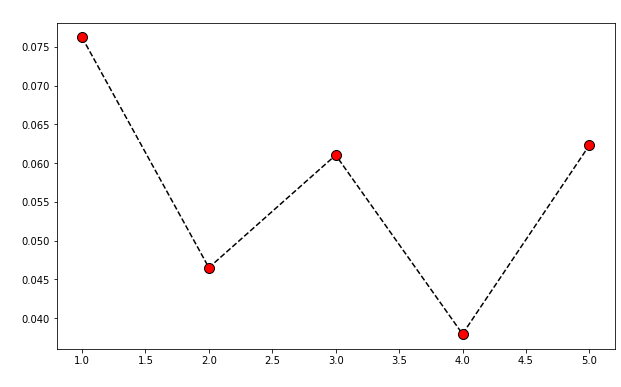

In [174]:
plt.figure(figsize=(10,6))
plt.plot(range(1,6), mse_per_fold ,color='black', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Squared', color="white")
plt.xlabel('Split-eration', color="white")
plt.ylabel('Error Rate', color="white");

In [175]:
# Change end date and Ticker for more stock predictions 
test_start = dt.datetime(2017,1,1)
test_end = dt.datetime(2017,4,30)
df_test = web.DataReader('TSLA','yahoo',test_start,test_end)
actual_stock_price = df_test.iloc[:, 1:2].values
target = df_test['Open']

In [176]:
data_set_total = pd.concat((train['Open'], df_test['Open']), axis = 0)
inputs = data_set_total[len(data_set_total) - len(df_test) - steps:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

steps = 60 
end_range = steps + len(actual_stock_price)

for i in range(steps, end_range):
  X_test.append(inputs[i-steps:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

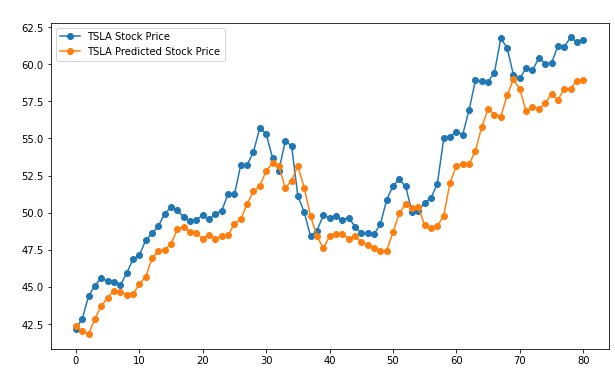

In [177]:
plt.figure(figsize=(10,6))
plt.plot(actual_stock_price, label = 'TSLA Stock Price',marker='o')
plt.plot(predicted_stock_price,label = 'TSLA Predicted Stock Price', marker='o')
plt.title('3 Month Stock Price Prediction',color="white")
plt.xlabel('Time (Days in test set)', color="white")
plt.ylabel('TSLA Stock Price', color="white")
plt.legend()
plt.show()

In [179]:
error_rate = []
for i in range(1, len(actual_stock_price)):
  if predicted_stock_price[i] != actual_stock_price[i]:
    error_rate.append( ( actual_stock_price[i] - predicted_stock_price[i])/2)
    
mse = np.mean(error_rate)
print(f' Mean Square Error {mse}')
print(f'Root Mean Errror {(mse)**0.5}')

 Mean Square Error 0.9450370788574218
Root Mean Errror 0.9721301758804846
